<font color='blue'> **21_HANI_VANI**</font> 

In [7]:
import os ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np; from pathlib import Path  ; import pandas as pd  
from modflow_devtools.misc import get_env, timed ; write=get_env("WRITE", True);run=get_env("RUN", True)
sim_ws  = Path("./21_HANI_VANI")                     ; sim_ws.mkdir(exist_ok=True)  ; #sim_name = "parameters"   
ex1     = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'    ; workspace = figs_path = sim_ws    ; output_folder = sim_ws   

In [8]:
length_units = "meters" ; time_units = "days"         ; nper = 1 ;nlay = 1 ;nrow = 51 ;ncol = 51 ;delr = 10 ;delc = 10 
parameters = {"ex-gwf-hani_a": {"angle1":  0, "xt3d": False} ,
              "ex-gwf-hani_b": {"angle1": 25, "xt3d": True}  ,"ex-gwf-hani_c": {"angle1": 90, "xt3d": False}}
top = 0 ;botm = -10 ;strt = 0 ;icelltype = 0 ;k11 = 1 ;k22 = 0.01 ; perlen = [1.0] ;nstp = [1] ;tsmult = [1.0] ;nouter = 50 ;
ninner = 100 ;hclose = 0.000000001 ; rclose = 0.000001 ;  pumping_rate = -1 ; tdis_ds = list(zip(perlen, nstp, tsmult))

In [9]:
def build_models(sim_name, angle1, xt3d):
    ibd = -1 * np.ones((nrow, ncol), dtype=int) ; ibd[1:-1, 1:-1] = 1 ; chdrow, chdcol = np.where(ibd == -1)
    chd_spd = [[0, i, j, 0.0] for i, j in zip(chdrow, chdcol)]
    head_filerecord = f"{sim_name}.hds" ; budget_filerecord = f"{sim_name}.cbc" ; rcloserecord = f"{rclose}strict"
    
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation  (sim_name=sim_name, sim_ws=sim_ws, exe_name=ex1)
    flopy.mf6.ModflowTdis (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms  (sim ,linear_acceleration = "bicgstab" ,outer_maximum = nouter ,outer_dvclose = hclose ,inner_maximum = ninner ,
                             inner_dvclose = hclose ,rcloserecord = rcloserecord)
    gwf = flopy.mf6.ModflowGwf    (sim ,modelname = sim_name ,save_flows = True)
    flopy.mf6.ModflowGwfdis (gwf ,length_units = length_units ,nlay = nlay ,nrow = nrow ,ncol = ncol ,top = top ,botm = botm)
    flopy.mf6.ModflowGwfnpf (gwf ,icelltype = icelltype ,k = k11 ,k22 = k22 ,angle1 = angle1 ,save_specific_discharge = True ,xt3doptions = xt3d)
    flopy.mf6.ModflowGwfic  (gwf, strt=strt)
    flopy.mf6.ModflowGwfchd (gwf ,stress_period_data = chd_spd ,pname = "CHD")
    flopy.mf6.ModflowGwfwel (gwf ,stress_period_data = [0 ,25 ,25 ,pumping_rate] ,pname = "WEL")
    flopy.mf6.ModflowGwfoc  (gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD","ALL"),("BUDGET","ALL")])
    return sim
def write_models(sim, silent=True):  sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=False):
    success, buff = sim.run_simulation(silent=silent, report=True)  ;  assert success, buff

def scenario(idx, silent=True):
    key = list(parameters.keys())[idx] ;     params = parameters[key].copy() ;     sim = build_models(key, **params)
    if write: write_models(sim, silent=silent)
    if run:   run_models(sim, silent=silent)
scenario(0); scenario(1) ; scenario(2)

run_models took 100.96 ms
run_models took 127.88 ms
run_models took 65.79 ms


In [10]:
s1=Path("21_HANI_VANI/ex-gwf-hani_a") ; sim = build_models('ex-gwf-hani_a',angle1=0, xt3d=False) ;gwf1=sim.get_model('ex-gwf-hani_a')
s1=Path("21_HANI_VANI/ex-gwf-hani_b") ; sim=flopy.mf6.MFSimulation.load(sim_ws=s1,exe_name=ex1,verbosity_level=0) ;gwf2=sim.get_model('ex-gwf-hani_b')
s1=Path("21_HANI_VANI/ex-gwf-hani_c") ; sim=flopy.mf6.MFSimulation.load(sim_ws=s1,exe_name=ex1,verbosity_level=0) ;gwf3=sim.get_model('ex-gwf-hani_c')

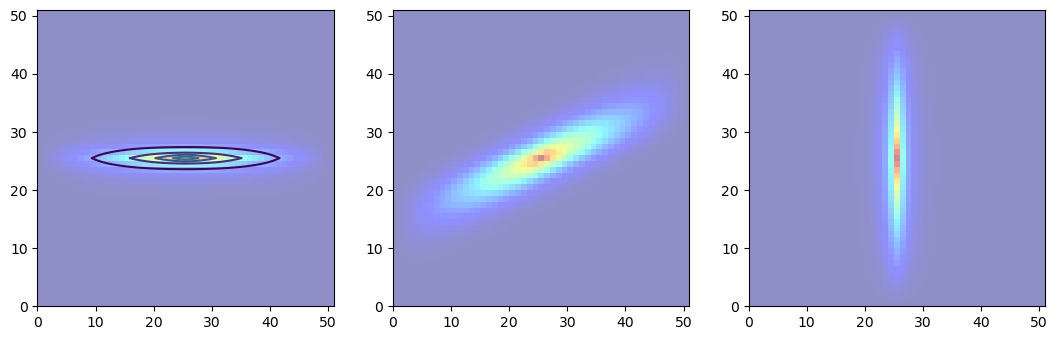

In [11]:
fig = plt.figure(figsize=(13, 4))                             
ax = fig.add_subplot(131, aspect="equal")                 ; head = gwf1.output.head().get_data()   ; h_L0 = pd.DataFrame(head[0,:,:])
pmv = flopy.plot.PlotMapView(model=gwf1, ax=ax, layer=0)  ; cb = pmv.plot_array(0 - head, cmap="jet", alpha=0.25)
cs = pmv.contour_array(0 - head, levels=np.arange(0.1, 1, 0.1))
ax = fig.add_subplot(132, aspect="equal")                 ; head = gwf2.output.head().get_data()   ; h_L0 = pd.DataFrame(head[0,:,:])
pmv = flopy.plot.PlotMapView(model=gwf2, ax=ax, layer=0)  ; cb = pmv.plot_array(0 - head, cmap="jet", alpha=0.25)
ax = fig.add_subplot(133, aspect="equal")                 ; head = gwf3.output.head().get_data()   ; h_L0 = pd.DataFrame(head[0,:,:])
pmv = flopy.plot.PlotMapView(model=gwf3, ax=ax, layer=0)  ; cb = pmv.plot_array(0 - head, cmap="jet", alpha=0.25)  ;  plt.show()